In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

%matplotlib inline

def pmin(data):
    print(data.dtype, end=' ')
    print(type(data), end=' ')
    if isinstance(data, np.ndarray):
        print(data.shape)
    print()

# Sine Wave Model

In [3]:
# https://stackoverflow.com/questions/13897316/approximating-the-sine-function-with-a-neural-network
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 300, 1
dtype = torch.float
device = torch.device('cuda:0')

# Define model
class TheModelClass(nn.Module):
    def __init__(self, D_in=1, H=10, D_out=1):
        super(TheModelClass, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass(D_in, H, D_out).to(device=device)
    
# Use the nn package to define our model and loss function.
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# )

model.eval()

loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([300, 1])
fc1.bias 	 torch.Size([300])
fc2.weight 	 torch.Size([300, 300])
fc2.bias 	 torch.Size([300])
fc4.weight 	 torch.Size([300, 300])
fc4.bias 	 torch.Size([300])
fc3.weight 	 torch.Size([1, 300])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140392968253160, 140392976654840, 140392968253304, 140392968253376, 140392968310928, 140392968311000, 140392968311072, 140392968311144]}]


100%|██████████| 50000/50000 [01:57<00:00, 425.84it/s]


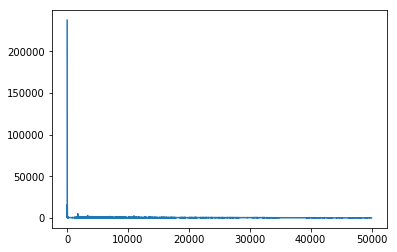

In [4]:
# for t in range(25000):
for t in tqdm(range(50000)):
    # gen random data
    Xin = np.random.randint(360*3, size=1000).reshape(1000,1)
    Yout = np.sin(np.deg2rad(Xin))
    
    x = torch.tensor(Xin, dtype=dtype, device=device)

    y = torch.tensor(Yout, dtype=dtype, device=device)
#     print(np.min(y.cpu().numpy()))
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
#     if t%1000==0:
#         print(t, loss.item())
    loss_history.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

plt.plot(loss_history)

torch.Size([1000, 1])


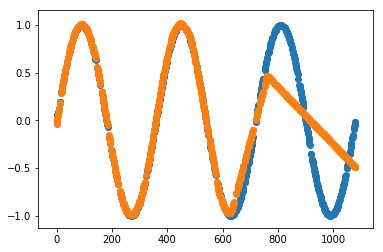

In [9]:
X_test = np.random.randint(360*3, size=1000).reshape(1000,1)
Y_test = np.sin(np.deg2rad(X_test))
y_pred = model(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

In [13]:
# save model
torch.save(model.state_dict(), 'sinNN')

#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [14]:
# load model
model_sin = TheModelClass(D_in, H, D_out).to(device=device)

# model_P = TheModelClass(*args, **kwargs)
model_sin.load_state_dict(torch.load('sinNN'))
model_sin.eval()

TheModelClass(
  (fc1): Linear(in_features=1, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

torch.Size([1000, 1])


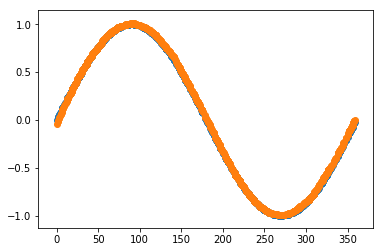

In [18]:
X_test = np.random.randint(360, size=1000).reshape(1000,1)
Y_test = np.sin(np.deg2rad(X_test))
y_pred = model_sin(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

# for n in range(X_test.shape[0]):
#     print(n, X_test[n], Y_test[n, 0], y_pred[n].item())

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

# Cos Model

In [3]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 300, 1
dtype = torch.float
device = torch.device('cuda:0')

# Define model
class TheModelClass(nn.Module):
    def __init__(self, D_in=1, H=10, D_out=1):
        super(TheModelClass, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass(D_in, H, D_out).to(device=device)
model.eval()
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([300, 1])
fc1.bias 	 torch.Size([300])
fc2.weight 	 torch.Size([300, 300])
fc2.bias 	 torch.Size([300])
fc4.weight 	 torch.Size([300, 300])
fc4.bias 	 torch.Size([300])
fc3.weight 	 torch.Size([1, 300])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [139667639899120, 139667639899192, 139667639898976, 139667639899264, 139667639899336, 139667639899408, 139667639899480, 139667639899552]}]


100%|██████████| 50000/50000 [02:02<00:00, 407.64it/s]


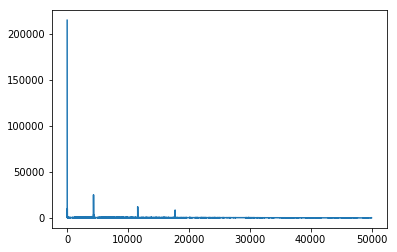

In [4]:
for t in tqdm(range(50000)):
    # gen random data
    Xin = np.random.randint(360*3, size=1000).reshape(1000,1)
    Yout = np.cos(np.deg2rad(Xin))
    x = torch.tensor(Xin, dtype=dtype, device=device)
    y = torch.tensor(Yout, dtype=dtype, device=device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    loss_history.append(loss.item())

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

plt.plot(loss_history)

torch.Size([1000, 1])


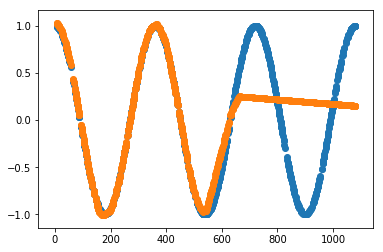

In [5]:
X_test = np.random.randint(360*3, size=1000).reshape(1000,1)
Y_test = np.cos(np.deg2rad(X_test))
y_pred = model(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

In [6]:
# save model
torch.save(model.state_dict(), 'cosNN')

#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [9]:
# load model
model_cos = TheModelClass(D_in, H, D_out).to(device=device)

# model_P = TheModelClass(*args, **kwargs)
model_cos.load_state_dict(torch.load('cosNN'))
model_cos.eval()

TheModelClass(
  (fc1): Linear(in_features=1, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

torch.Size([1000, 1])


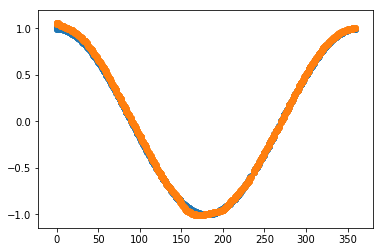

In [10]:
X_test = np.random.randint(360, size=1000).reshape(1000,1)
Y_test = np.cos(np.deg2rad(X_test))
y_pred = model_sin(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

# for n in range(X_test.shape[0]):
#     print(n, X_test[n], Y_test[n, 0], y_pred[n].item())

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)